In [1]:
# based on https://github.com/e-hulten/planar-flows

In [2]:
%config Completer.use_jedi = False

In [18]:
import torch
import torch.nn as nn
from torch import Tensor
from typing import Tuple, Callable

from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np

## Planar Flow


$g(\mathbf{z}) = \mathbf{z} + \mathbf{u}h(\mathbf{w}^T\mathbf{z} + b)$


$\theta = \{\mathbf{u,w} \in \mathbb{R}^d, b \in \mathbb{R}\}$

$\dfrac{\partial g(\mathbf{z}, \theta)}{\partial \mathbf{z}} =  \mathbf{I} + \mathbf{u}h'(\mathbf{w}^T\mathbf{z} + b)\mathbf{w}^T$

$\det \left|\dfrac{\partial g(\mathbf{z}, \theta)}{\partial \mathbf{z}}\right| =
\left(1 + h'(\mathbf{w}^T\mathbf{z} + b)\mathbf{w}^T\mathbf{I}^{-1}\mathbf{u} \right) \det(\mathbf{I}) =
1 + h'(\mathbf{w}^T\mathbf{z} + b)\mathbf{w}^T \mathbf{u}$

In [79]:
class PlanarTransform(nn.Module):
    """Implementation of the invertible transformation used in planar flow:
        f(z) = z + u * h(dot(w.T, z) + b)
    See Section 4.1 in https://arxiv.org/pdf/1505.05770.pdf. 
    """

    def __init__(self, dim: int = 2):
        """Initialise weights and bias.
        
        Args:
            dim: Dimensionality of the distribution to be estimated.
        """
        super().__init__()
        self.w = nn.Parameter(torch.randn(1, dim).normal_(0, 0.1))
        self.b = nn.Parameter(torch.randn(1).normal_(0, 0.1))
        self.u = nn.Parameter(torch.randn(1, dim).normal_(0, 0.1))

    def forward(self, z: Tensor):
        if torch.mm(self.u, self.w.T) < -1:
            self.get_u_hat()

        return z + self.u * nn.Tanh()(torch.mm(z, self.w.T) + self.b)

    def log_det_J(self, z: Tensor):
        if torch.mm(self.u, self.w.T) < -1:
            self.get_u_hat()
        a = torch.mm(z, self.w.T) + self.b
        psi = (1 - nn.Tanh()(a) ** 2) * self.w
        abs_det = (1 + torch.mm(self.u, psi.T)).abs()
        log_det = torch.log(1e-4 + abs_det)

        return log_det

    def get_u_hat(self):
        # return None
        """Enforce w^T u >= -1. When using h(.) = tanh(.), this is a sufficient condition 
        for invertibility of the transformation f(z). See Appendix A.1.
        """
        wtu = torch.mm(self.u, self.w.T)
        m_wtu = -1 + torch.log(1 + torch.exp(wtu))
        self.u.data = (
            self.u + (m_wtu - wtu) * self.w / torch.norm(self.w, p=2, dim=1) ** 2
        )

<img src="pics/u_hat.jpg" width=800 height=800 />

In [80]:
class PlanarFlow(nn.Module):
    def __init__(self, dim: int = 2, K: int = 6):
        """Make a planar flow by stacking planar transformations in sequence.
        Args:
            dim: Dimensionality of the distribution to be estimated.
            K: Number of transformations in the flow. 
        """
        super().__init__()
        self.layers = [PlanarTransform(dim) for _ in range(K)]
        self.model = nn.Sequential(*self.layers)

    def forward(self, z: Tensor):
        log_det_J = 0
        for layer in self.layers:
            z = layer(z)
            log_det_J+=layer.log_det_J(z)
        
        return z, log_det_J
    
    def seq_forward(self, z: Tensor):
        res = []
        with torch.no_grad():
            for layer in self.layers:
                z = layer(z)
                res.append(z)

        
        return res

## Forward KL

In [81]:
from sklearn.datasets import make_moons

def generate_moons_data(count):
    data, labels = make_moons(n_samples=count, noise=0.1)
    data = data.astype('float32')
    split = int(0.8 * count)
    train_data, test_data = data[:split], data[split:]
    train_labels, test_labels = labels[:split], labels[split:]
    return train_data, train_labels, test_data, test_labels

def visualize_2d_data(train_data, test_data, train_labels=None, test_labels=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.set_title('train', fontsize=16)
    ax1.scatter(train_data[:, 0], train_data[:, 1], s=1, c=train_labels)
    ax1.tick_params(labelsize=16)
    # ax1.set_yticks(fontsize=16)
    ax2.set_title('test', fontsize=16)
    ax2.scatter(test_data[:, 0], test_data[:, 1], s=1, c=test_labels)
    ax2.tick_params(labelsize=16)
    plt.show()
    
    
def visualize_seq(seq_data, labels=None, figsize=None, b=5):
    a = len(seq_data) // b + 1*((len(seq_data) % b)>0)
    if figsize is None:
        figsize = (5*b, 5*a)
    
    fig, axs = plt.subplots(a, b, figsize=figsize)
    if len(seq_data)<=b:
        for k,data in enumerate(seq_data):
            axs[k].set_title(k, fontsize=16)
            axs[k].scatter(data[:, 0], data[:, 1], s=1, c=labels)
            axs[k].tick_params(labelsize=16)


    else:
        for k,data in enumerate(seq_data):
            i = k//b
            j = k%b
            axs[i][j].set_title(k, fontsize=16)
            axs[i][j].scatter(data[:, 0], data[:, 1], s=1, c=labels)
            axs[i][j].tick_params(labelsize=16)

    plt.show()

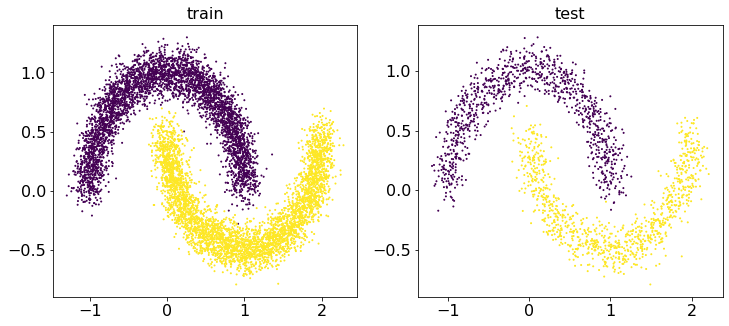

In [82]:
COUNT = 10000

train_data, train_labels, test_data, test_labels = generate_moons_data(COUNT)
visualize_2d_data(train_data, test_data, train_labels, test_labels)

In [83]:
####

<img src="pics/forwardkl.jpg" width=800 height=800 />

<img src="pics/forward_for_flow.jpg" width=800 height=800 />

In [85]:
from torch.distributions import MultivariateNormal
from torch import Tensor

class ForwardKL(nn.Module):
    def __init__(self):
        super().__init__()
        self.base_distr = MultivariateNormal(torch.zeros(2), torch.eye(2))

    def forward(self, z: Tensor, sum_log_det_J: float):
        log_p_z = self.base_distr.log_prob(z)
        return -1*(log_p_z + sum_log_det_J).mean()

In [86]:
flow_length = 64
dim = 2

model = PlanarFlow(dim, K=flow_length)
loss_f = ForwardKL()

In [87]:
EPOCHS = 60
BATCH_SIZE = 256

lr = 1e-2
optimiser = torch.optim.Adam(model.parameters(), lr=lr)

In [88]:
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

EPOCH 0: mean loss  1.9844


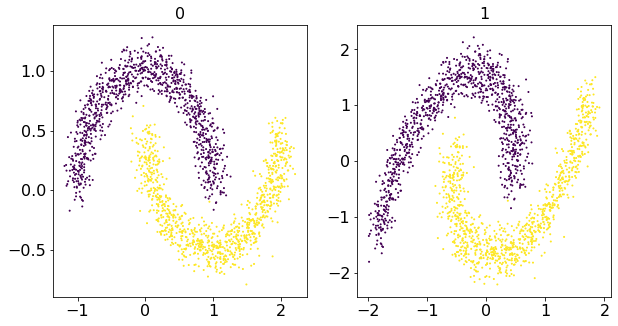

EPOCH 1: mean loss  1.9095
EPOCH 2: mean loss  1.905
EPOCH 3: mean loss  1.8986
EPOCH 4: mean loss  1.8479
EPOCH 5: mean loss  1.7886
EPOCH 6: mean loss  1.7694
EPOCH 7: mean loss  1.7632
EPOCH 8: mean loss  1.7552
EPOCH 9: mean loss  1.7316
EPOCH 10: mean loss  1.7146


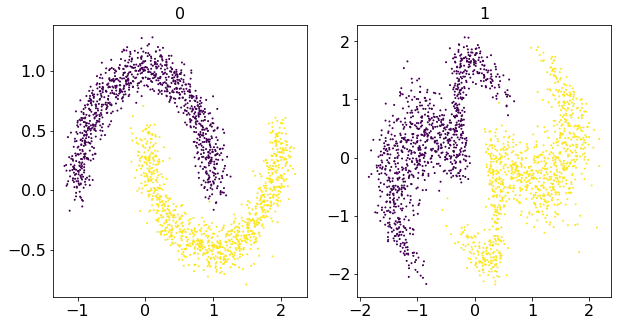

EPOCH 11: mean loss  1.6737
EPOCH 12: mean loss  1.651
EPOCH 13: mean loss  1.6392
EPOCH 14: mean loss  1.622
EPOCH 15: mean loss  1.6042
EPOCH 16: mean loss  1.567
EPOCH 17: mean loss  1.4914
EPOCH 18: mean loss  1.4235
EPOCH 19: mean loss  1.3963
EPOCH 20: mean loss  1.3892


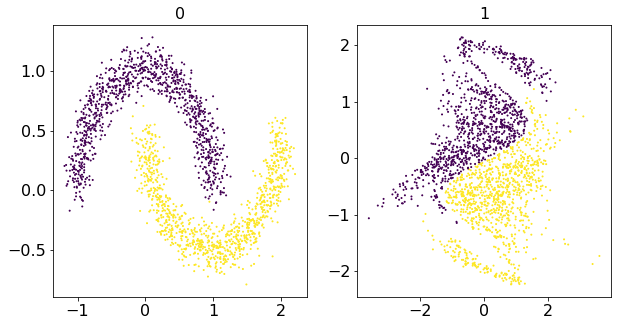

EPOCH 21: mean loss  1.3801
EPOCH 22: mean loss  1.3574
EPOCH 23: mean loss  1.3499
EPOCH 24: mean loss  1.3735
EPOCH 25: mean loss  1.3485
EPOCH 26: mean loss  1.3371
EPOCH 27: mean loss  1.3339
EPOCH 28: mean loss  1.3463
EPOCH 29: mean loss  1.3162
EPOCH 30: mean loss  1.3199


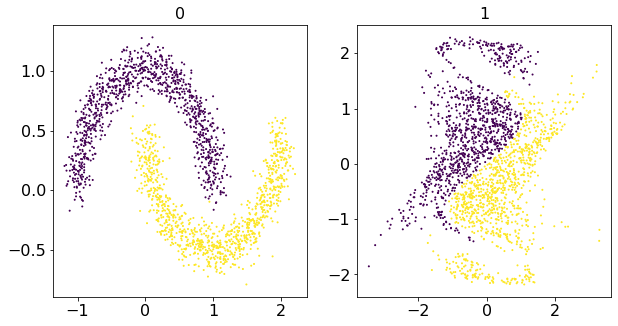

EPOCH 31: mean loss  1.33
EPOCH 32: mean loss  1.3227
EPOCH 33: mean loss  1.3083
EPOCH 34: mean loss  1.3084
EPOCH 35: mean loss  1.3252
EPOCH 36: mean loss  1.317
EPOCH 37: mean loss  1.3104
EPOCH 38: mean loss  1.2927
EPOCH 39: mean loss  1.3026
EPOCH 40: mean loss  1.3077


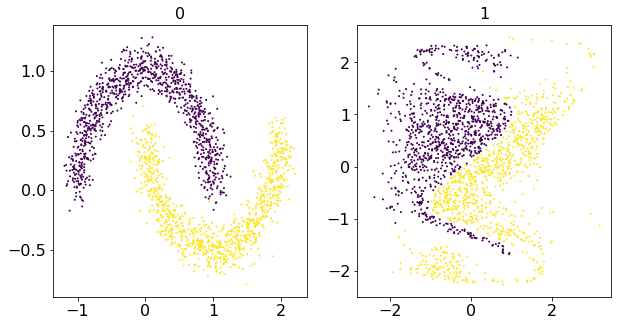

EPOCH 41: mean loss  1.3224
EPOCH 42: mean loss  1.3069
EPOCH 43: mean loss  1.2932
EPOCH 44: mean loss  1.288
EPOCH 45: mean loss  1.3085
EPOCH 46: mean loss  1.3025
EPOCH 47: mean loss  1.2891
EPOCH 48: mean loss  1.2985
EPOCH 49: mean loss  1.3125
EPOCH 50: mean loss  1.301


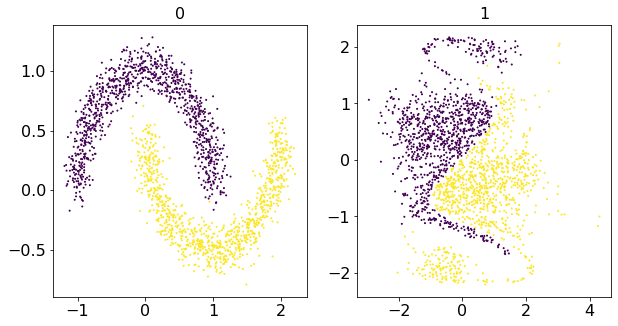

EPOCH 51: mean loss  1.3173
EPOCH 52: mean loss  1.3021
EPOCH 53: mean loss  1.28
EPOCH 54: mean loss  1.2971
EPOCH 55: mean loss  1.2924
EPOCH 56: mean loss  1.2884
EPOCH 57: mean loss  1.2979
EPOCH 58: mean loss  1.2908
EPOCH 59: mean loss  1.2978


In [89]:
for i in range(EPOCHS):
    train_losses = []
    for batch in train_loader:
        zk, log_det_J = model(batch)
        loss = loss_f(zk, log_det_J)
        
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        train_losses.append(loss.detach().numpy())

    print(f'EPOCH {i}: mean loss ',np.round(np.mean(train_losses), 4))
    if not (i % 10):
        with torch.no_grad():
            test_res, log_det_J = model(torch.from_numpy(test_data))
        
        visualize_seq([test_data, test_res], test_labels, figsize=(10,5), b=2)

In [26]:
def show_2d_densities(densities, title='Densities'):
    plt.figure()
    plt.title(title)
    dx, dy = 0.025, 0.025
    x_lim = (-1.5, 2.5)
    y_lim = (-1, 1.5)
    y, x = np.mgrid[slice(y_lim[0], y_lim[1] + dy, dy),
                    slice(x_lim[0], x_lim[1] + dx, dx)]
    plt.pcolor(x, y, densities.reshape([y.shape[0], y.shape[1]]))
    plt.pcolor(x, y, densities.reshape([y.shape[0], y.shape[1]]))
    plt.xlabel('z1')
    plt.ylabel('z2')
    plt.show()

In [49]:
def get_densities(model):
    base_distr = MultivariateNormal(torch.zeros(2), torch.eye(2))

    dx, dy = 0.025, 0.025
    x_lim = (-1.5, 2.5)
    y_lim = (-1, 1.5)
    y, x = np.mgrid[slice(y_lim[0], y_lim[1] + dy, dy),
                    slice(x_lim[0], x_lim[1] + dx, dx)]
    mesh_xs = torch.FloatTensor(np.stack([x, y], axis=2).reshape(-1, 2))
    
    with torch.no_grad():
        z, sum_log_det_J = model(mesh_xs)
    
    log_p_z = base_distr.log_prob(z)
    
    return torch.exp(log_p_z + sum_log_det_J).numpy()

<ipython-input-26-1650aab65195>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(x, y, densities.reshape([y.shape[0], y.shape[1]]))
<ipython-input-26-1650aab65195>:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(x, y, densities.reshape([y.shape[0], y.shape[1]]))


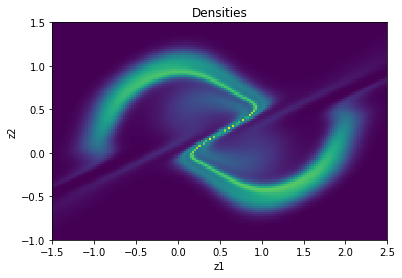

In [90]:
show_2d_densities(get_densities(model))

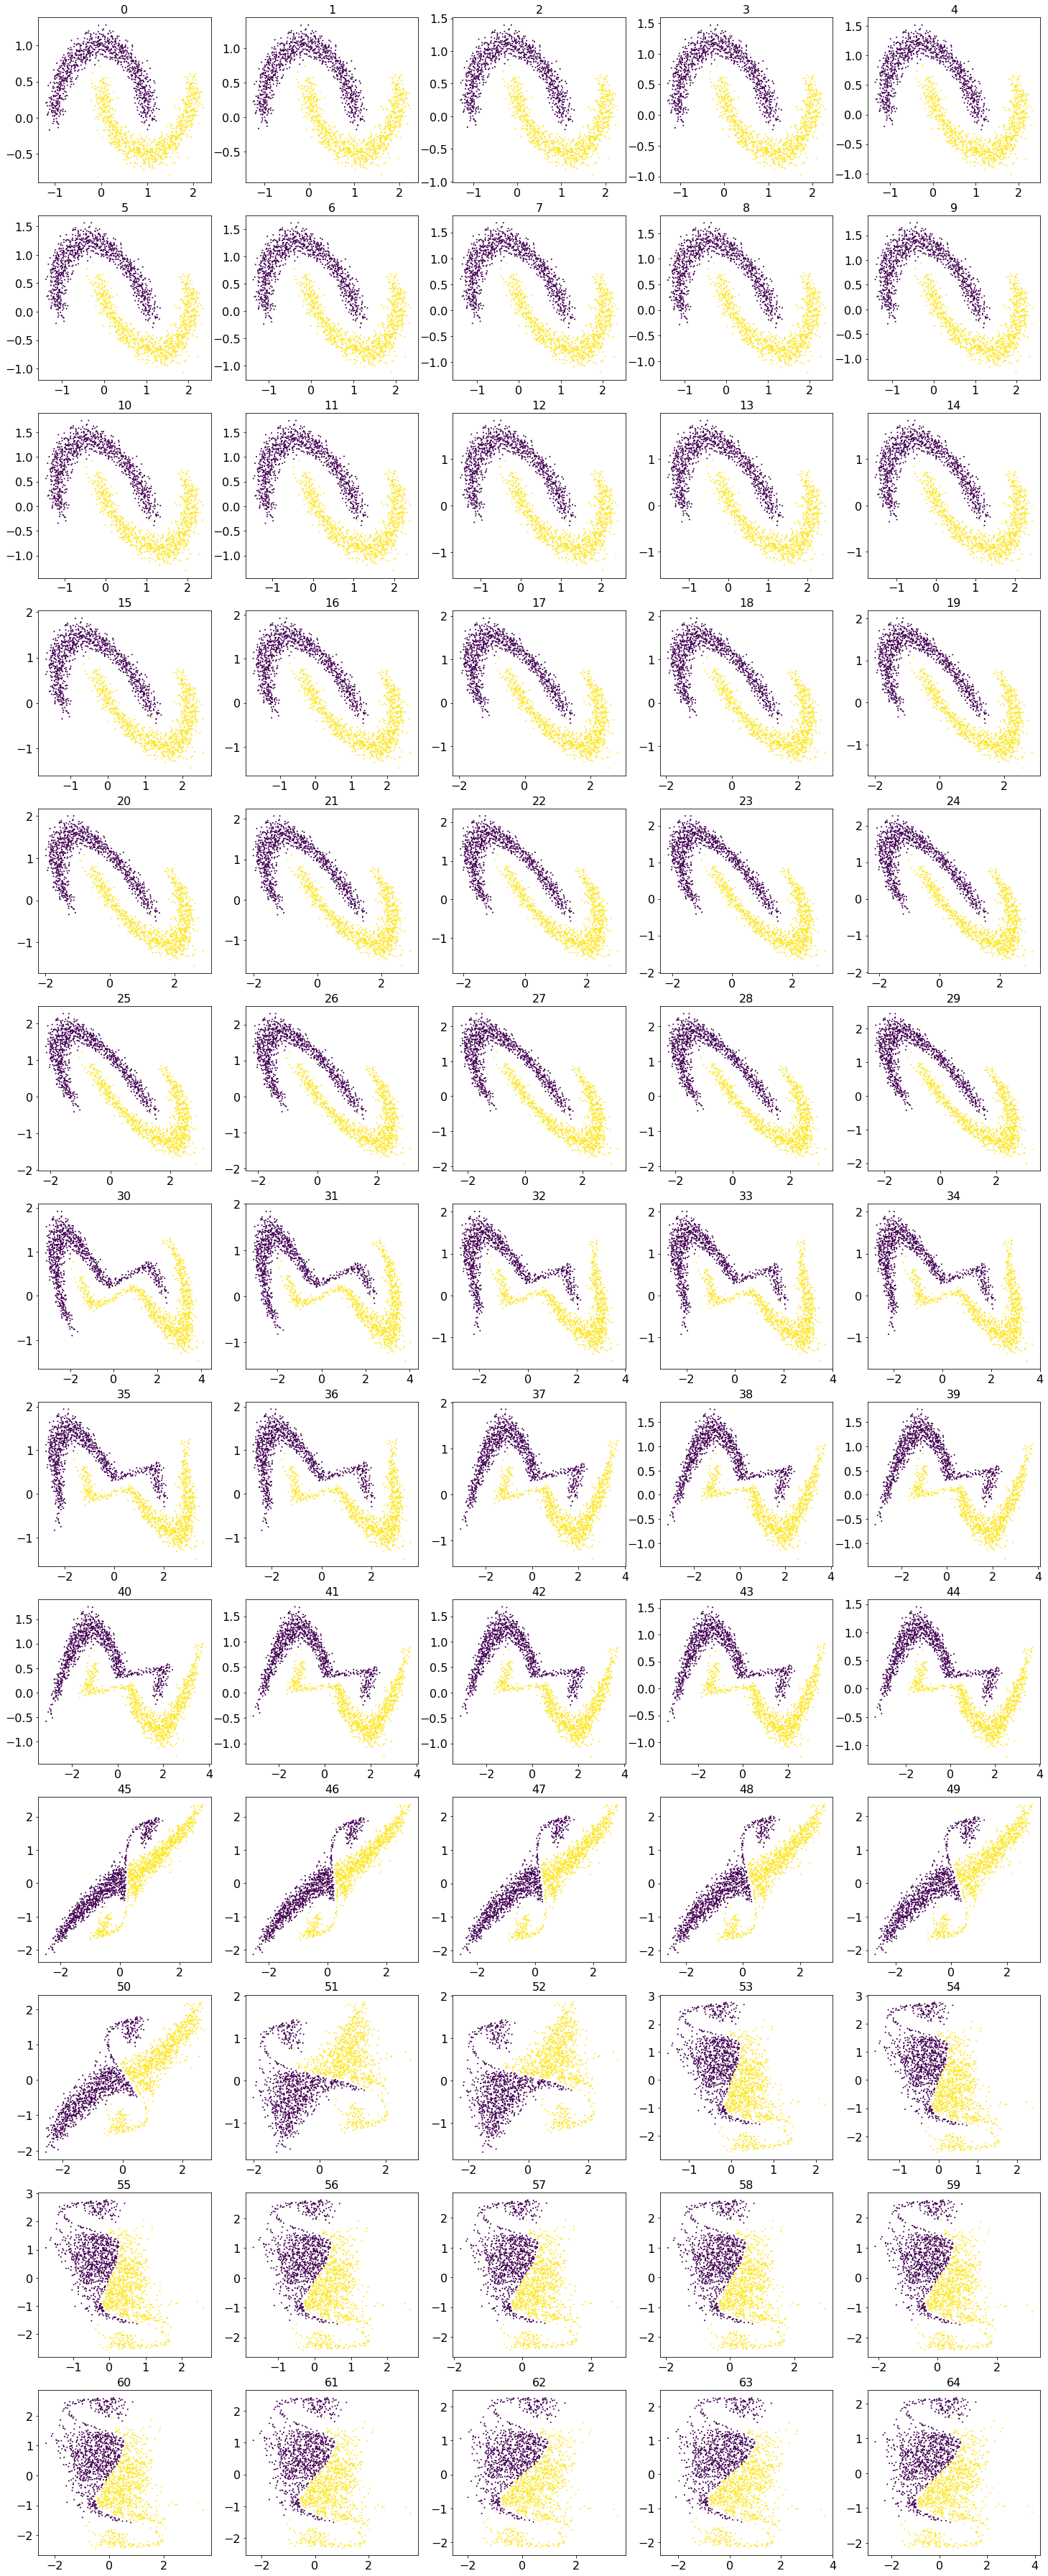

In [91]:
visualize_seq([test_data]+model.seq_forward(torch.from_numpy(test_data)), test_labels)

## Reverse KL

In [51]:
class TargetDistribution:
    def __init__(self, name: str):
        """Define target distribution. 
        Args:
            name: The name of the target density to use. 
                  Valid choices: ["U_1", "U_2", "U_3", "U_4", "ring"].
                  
        !!! We are working with - log, so to get density we should use P = torch.exp(-density(Z))
        """
        self.func = self.get_target_distribution(name)

    def __call__(self, z: Tensor) -> Tensor:
        return self.func(z)

    @staticmethod
    def get_target_distribution(name: str) -> Callable[[Tensor], Tensor]:
        w1 = lambda z: torch.sin(2 * np.pi * z[:, 0] / 4)
        w2 = lambda z: 3 * torch.exp(-0.5 * ((z[:, 0] - 1) / 0.6) ** 2)
        w3 = lambda z: 3 * torch.sigmoid((z[:, 0] - 1) / 0.3)

        if name == "U_1":

            def U_1(z):
                u = 0.5 * ((torch.norm(z, 2, dim=1) - 2) / 0.4) ** 2
                u = u - torch.log(
                    torch.exp(-0.5 * ((z[:, 0] - 2) / 0.6) ** 2)
                    + torch.exp(-0.5 * ((z[:, 0] + 2) / 0.6) ** 2)
                )
                return u

            return U_1
        elif name == "U_2":

            def U_2(z):
                u = 0.5 * ((z[:, 1] - w1(z)) / 0.4) ** 2
                return u

            return U_2
        elif name == "U_3":

            def U_3(z):
                u = -torch.log(
                    torch.exp(-0.5 * ((z[:, 1] - w1(z)) / 0.35) ** 2)
                    + torch.exp(-0.5 * ((z[:, 1] - w1(z) + w2(z)) / 0.35) ** 2)
                    + 1e-6
                )
                return u

            return U_3
        elif name == "U_4":

            def U_4(z):
                u = -torch.log(
                    torch.exp(-0.5 * ((z[:, 1] - w1(z)) / 0.4) ** 2)
                    + torch.exp(-0.5 * ((z[:, 1] - w1(z) + w3(z)) / 0.35) ** 2)
                    + 1e-6
                )
                return u

            return U_4
        elif name == "ring":

            def ring_density(z):
                exp1 = torch.exp(-0.5 * ((z[:, 0] - 2) / 0.8) ** 2)
                exp2 = torch.exp(-0.5 * ((z[:, 0] + 2) / 0.8) ** 2)
                u = 0.5 * ((torch.norm(z, 2, dim=1) - 4) / 0.4) ** 2
                u = u - torch.log(exp1 + exp2 + 1e-6)
                return u

            return ring_density
        
        
        
def plot_density(density, xlim=4, ylim=4, ax=None, cmap="Blues"):
    x = y = np.linspace(-xlim, xlim, 300)
    X, Y = np.meshgrid(x, y)
    shape = X.shape
    X_flatten, Y_flatten = np.reshape(X, (-1, 1)), np.reshape(Y, (-1, 1))
    Z = torch.from_numpy(np.concatenate([X_flatten, Y_flatten], 1))
    U = torch.exp(-density(Z))
    U = U.reshape(shape)
    if ax is None:
        fig = plt.figure(figsize=(7, 7))
        ax = fig.add_subplot(111)

    ax.set_xlim(-xlim, xlim)
    ax.set_ylim(-xlim, xlim)
    ax.set_aspect(1)

    ax.pcolormesh(X, Y, U, cmap=cmap, rasterized=True)
    ax.tick_params(
        axis="both",
        left=False,
        top=False,
        right=False,
        bottom=False,
        labelleft=False,
        labeltop=False,
        labelright=False,
        labelbottom=False,
    )
    return ax


def plot_available_distributions():
    target_distributions = ["U_1", "U_2", "U_3", "U_4", "ring"]
    cmaps = ["Reds", "Purples", "Oranges", "Greens", "Blues"]
    fig, axes = plt.subplots(1, len(target_distributions), figsize=(20, 5))
    for i, distr in enumerate(target_distributions):
        axlim = 7 if distr == "ring" else 5
        density = TargetDistribution(distr)
        plot_density(density, xlim=axlim, ylim=axlim, ax=axes[i], cmap=cmaps[i])
        axes[i].set_title(f"Name: '{distr}'", size=16)
        plt.setp(axes, xticks=[], yticks=[])
    plt.show()

<ipython-input-51-6460f90b2e2a>:90: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(X, Y, U, cmap=cmap, rasterized=True)


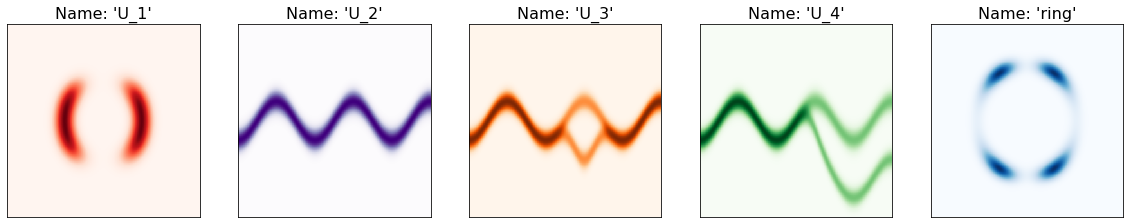

In [52]:
plot_available_distributions()

In [53]:
target_distr = 'U_4'

In [54]:
density = TargetDistribution(target_distr)

<ipython-input-51-6460f90b2e2a>:90: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(X, Y, U, cmap=cmap, rasterized=True)


<AxesSubplot:>

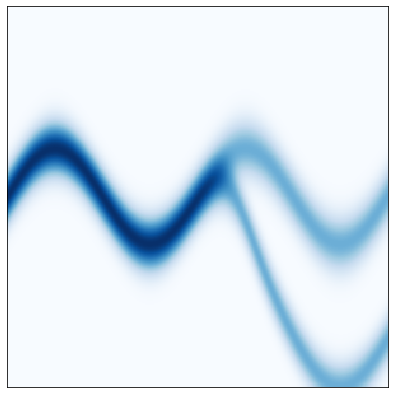

In [55]:
plot_density(density)

<img src="pics/reversekl.jpg" width=800 height=800 />

<img src="pics/reverse_for_flow.jpg" width=800 height=800 />

In [60]:
class ReverseKL(nn.Module):
    def __init__(self, distribution: TargetDistribution):
        super().__init__()
        self.distr = distribution
        self.base_distr = MultivariateNormal(torch.zeros(2), torch.eye(2))

    def forward(self, z0: Tensor, z: Tensor, sum_log_det_J: float):
        base_log_prob = self.base_distr.log_prob(z0)
        target_density_log_prob = -self.distr(z)
        
        return (base_log_prob - sum_log_det_J - target_density_log_prob).mean()

In [97]:
#####

In [61]:
flow_length = 64
dim = 2

model = PlanarFlow(dim, K=flow_length)
loss_f = ReverseKL(density)
base_distr = MultivariateNormal(torch.zeros(2), torch.eye(2))

In [78]:
torch.exp(-density(torch.from_numpy(np.zeros((1,2)))))

tensor([1.9574], dtype=torch.float64)

In [62]:
EPOCHS = 60
BATCH_SIZE = 256
BATCHES_PER_EPOCH = 50

lr = 5e-3
optimiser = torch.optim.Adam(model.parameters(), lr=lr)

EPOCH 0: mean loss  -1.1552


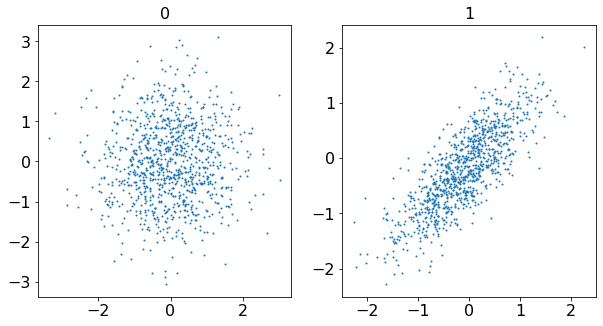

EPOCH 1: mean loss  -1.4166
EPOCH 2: mean loss  -1.4365
EPOCH 3: mean loss  -1.4398
EPOCH 4: mean loss  -1.471
EPOCH 5: mean loss  -1.6655
EPOCH 6: mean loss  -2.0627
EPOCH 7: mean loss  -2.1505
EPOCH 8: mean loss  -2.2049
EPOCH 9: mean loss  -2.2159
EPOCH 10: mean loss  -2.24


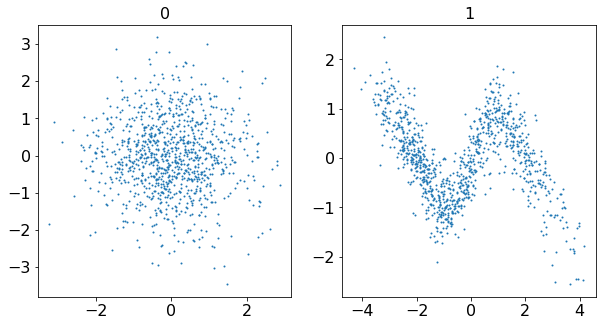

EPOCH 11: mean loss  -2.2319
EPOCH 12: mean loss  -2.2763
EPOCH 13: mean loss  -2.2868
EPOCH 14: mean loss  -2.2947
EPOCH 15: mean loss  -2.3112
EPOCH 16: mean loss  -2.3318
EPOCH 17: mean loss  -2.3358
EPOCH 18: mean loss  -2.3275
EPOCH 19: mean loss  -2.3348
EPOCH 20: mean loss  -2.3416


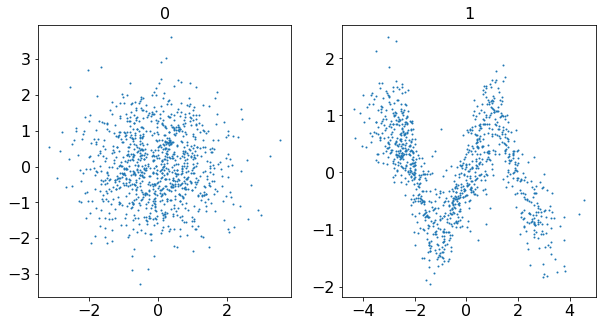

EPOCH 21: mean loss  -2.3521
EPOCH 22: mean loss  -2.3587
EPOCH 23: mean loss  -2.3422
EPOCH 24: mean loss  -2.3641
EPOCH 25: mean loss  -2.3816
EPOCH 26: mean loss  -2.3746
EPOCH 27: mean loss  -2.3768
EPOCH 28: mean loss  -2.3854
EPOCH 29: mean loss  -2.4029
EPOCH 30: mean loss  -2.3853


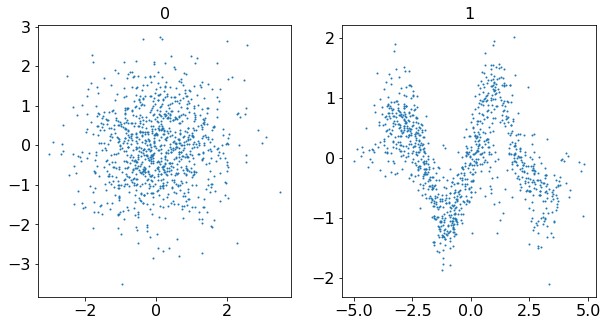

EPOCH 31: mean loss  -2.4076
EPOCH 32: mean loss  -2.4236
EPOCH 33: mean loss  -2.4671
EPOCH 34: mean loss  -2.5103
EPOCH 35: mean loss  -2.5587
EPOCH 36: mean loss  -2.5839
EPOCH 37: mean loss  -2.5906
EPOCH 38: mean loss  -2.6047
EPOCH 39: mean loss  -2.6124
EPOCH 40: mean loss  -2.6314


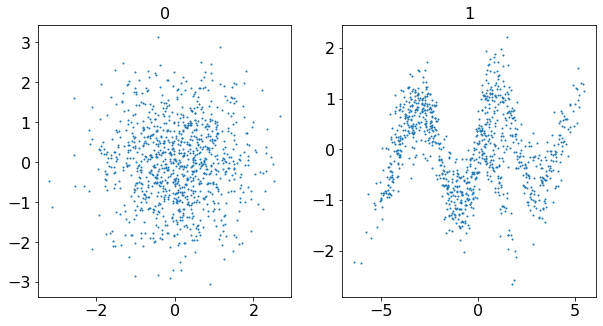

EPOCH 41: mean loss  -2.6354
EPOCH 42: mean loss  -2.6633
EPOCH 43: mean loss  -2.6757
EPOCH 44: mean loss  -2.685
EPOCH 45: mean loss  -2.7009
EPOCH 46: mean loss  -2.6973
EPOCH 47: mean loss  -2.7224
EPOCH 48: mean loss  -2.7452
EPOCH 49: mean loss  -2.7411
EPOCH 50: mean loss  -2.7545


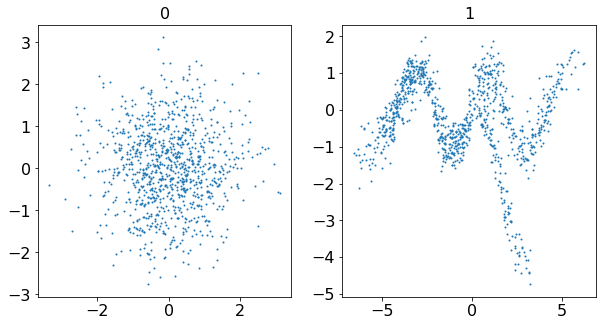

EPOCH 51: mean loss  -2.7315
EPOCH 52: mean loss  -2.7638
EPOCH 53: mean loss  -2.7737
EPOCH 54: mean loss  -2.785
EPOCH 55: mean loss  -2.784
EPOCH 56: mean loss  -2.7912
EPOCH 57: mean loss  -2.7947
EPOCH 58: mean loss  -2.8021
EPOCH 59: mean loss  -2.818


In [63]:
for i in range(EPOCHS):
    train_losses = []
    for batch in range(BATCHES_PER_EPOCH):
        batch = base_distr.sample_n(BATCH_SIZE)
        
        zk, log_jacobians = model(batch)
        loss = loss_f(batch, zk, log_jacobians)
        
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        
        train_losses.append(loss.detach().numpy())
    
    print(f'EPOCH {i}: mean loss ',np.round(np.mean(train_losses), 4))
    if not (i % 10):
        test_data = base_distr.sample_n(1000)
        test_labels = None
        
        with torch.no_grad():
            test_res, log_jacobian = model(test_data)

        visualize_seq([test_data, test_res], test_labels, figsize=(10,5), b=2)

In [66]:
test_data.shape

torch.Size([1000, 2])

In [67]:
test_data = base_distr.sample_n(1000)
test_labels = np.linalg.norm(test_data.numpy(),axis=1) // 0.5

test_res = model.seq_forward(test_data)

/Users/a18881350/miniconda3/lib/python3.8/site-packages/torch/distributions/distribution.py:134: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


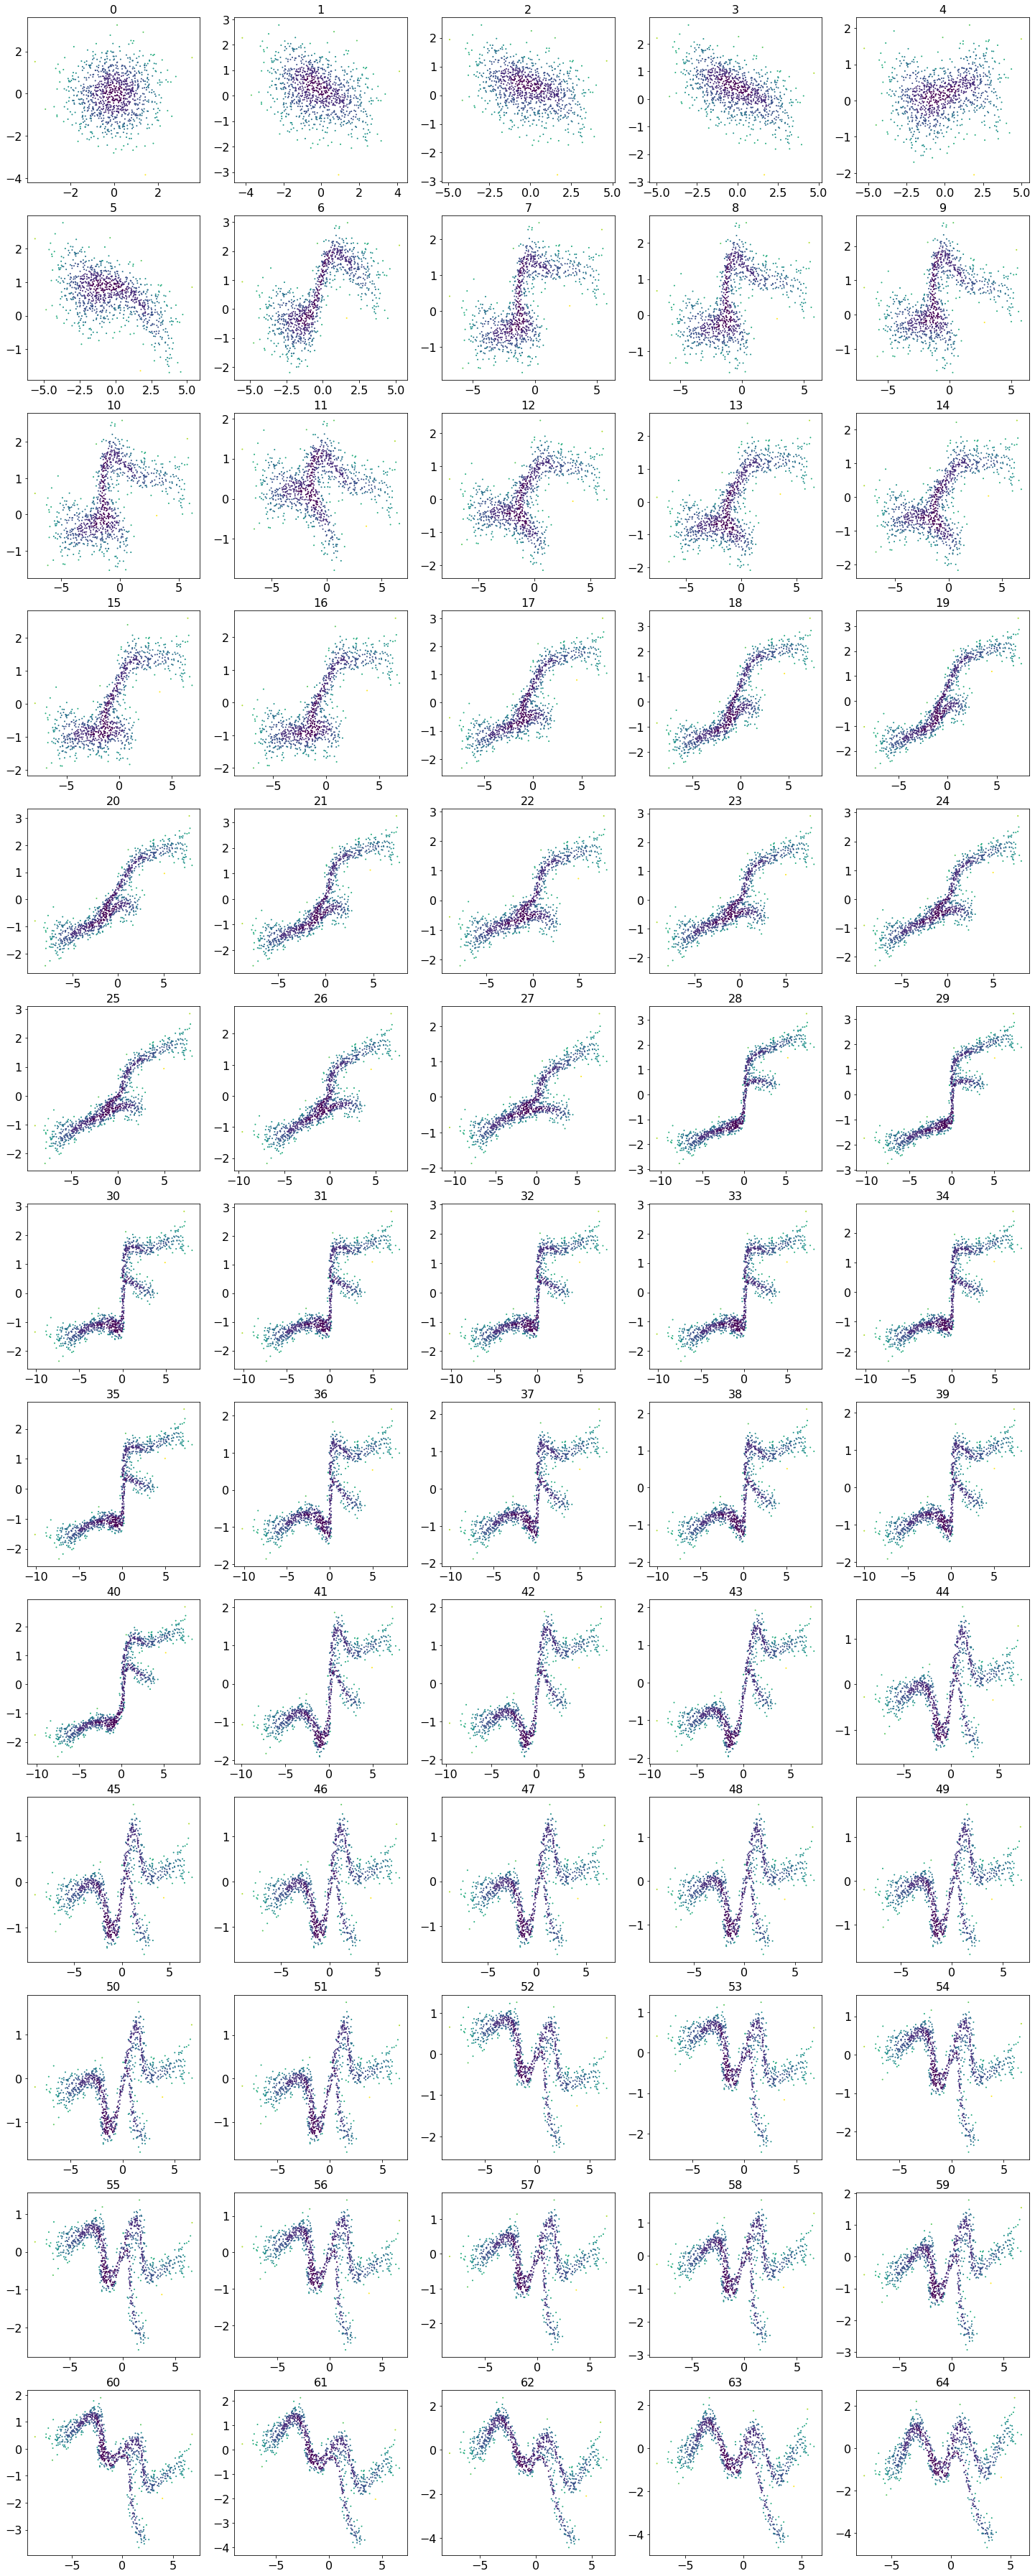

In [69]:
visualize_seq([test_data]+test_res, test_labels)